In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input
import numpy as np
import matplotlib.pyplot as plt
import pathlib

In [2]:
TRAINING_DIR = "data_1/train"
VALIDATION_DIR = "data_1/test"

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    # rotation_range=40,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.2,
    # zoom_range=0.2,
    # horizontal_flip=True,
    # fill_mode='nearest',
    # validation_split=0.1
)

train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    class_mode='categorical',
                                                    batch_size=1,
                                                    target_size=(150, 150))

Found 5187 images belonging to 40 classes.


In [3]:
validation_datagen = ImageDataGenerator(
    rescale=1.0/255
)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                        class_mode='categorical',
                                                        batch_size=1,
                                                        target_size=(150, 150))


Found 1362 images belonging to 40 classes.


In [4]:
pre_trained_model = ResNet50(weights="imagenet", include_top=False,
                                input_tensor=Input(shape=(150, 150, 3)))

for layer in pre_trained_model.layers:
    layer.trainable = False

last_output = pre_trained_model.output


In [11]:
x = tf.keras.layers.Flatten(name="flatten")(last_output)
# x = tf.keras.layers.Dropout(0.3)(x)
# x = tf.keras.layers.Dense(62, activation="relu")(x)
# x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(40, activation='softmax')(x)

model = tf.keras.models.Model(pre_trained_model.input, x)

model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 156, 156, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 75, 75, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 75, 75, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [12]:
int_lr = 1e-4
num_epochs = 50

optimizer = tf.optimizers.Adam(learning_rate=int_lr)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [13]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.9 and logs.get('accuracy')>0.9):
      print('accuracy and validation accuracy reach 90%')
      self.model.stop_training = True

mycallback = myCallback()

In [14]:
H = model.fit(train_generator,
              epochs=num_epochs,
              validation_data=validation_generator,
              #callbacks=mycallback
              )


Epoch 1/50
5187/5187 [==============================] - 567s 109ms/step - loss: 3.7506 - accuracy: 0.0754 - val_loss: 3.6760 - val_accuracy: 0.0749
Epoch 2/50
5187/5187 [==============================] - 558s 108ms/step - loss: 3.3962 - accuracy: 0.1278 - val_loss: 3.4858 - val_accuracy: 0.0984
Epoch 3/50
5187/5187 [==============================] - 549s 106ms/step - loss: 3.2026 - accuracy: 0.1591 - val_loss: 3.4436 - val_accuracy: 0.1615
Epoch 4/50
5187/5187 [==============================] - 543s 105ms/step - loss: 3.0654 - accuracy: 0.1885 - val_loss: 3.1441 - val_accuracy: 0.1997
Epoch 5/50
5187/5187 [==============================] - 541s 104ms/step - loss: 2.9484 - accuracy: 0.2217 - val_loss: 3.2158 - val_accuracy: 0.1256
Epoch 6/50
5187/5187 [==============================] - 523s 101ms/step - loss: 2.8421 - accuracy: 0.2400 - val_loss: 3.2521 - val_accuracy: 0.1586
Epoch 7/50
5187/5187 [==============================] - 528s 102ms/step - loss: 2.7627 - accuracy: 0.2599 - val_

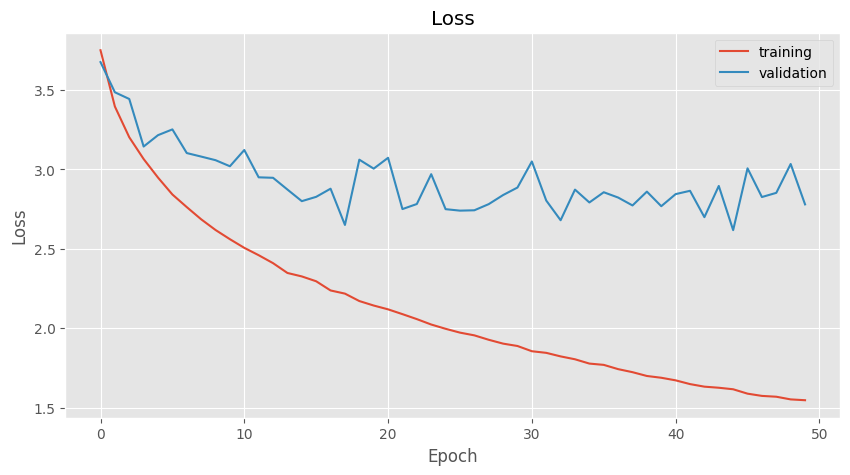

In [15]:
plt.style.use("ggplot")
plt.figure(figsize=(10, 5))
plt.plot(np.arange(0, num_epochs), H.history["loss"], label="training")
plt.plot(np.arange(0, num_epochs), H.history["val_loss"], label="validation")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()


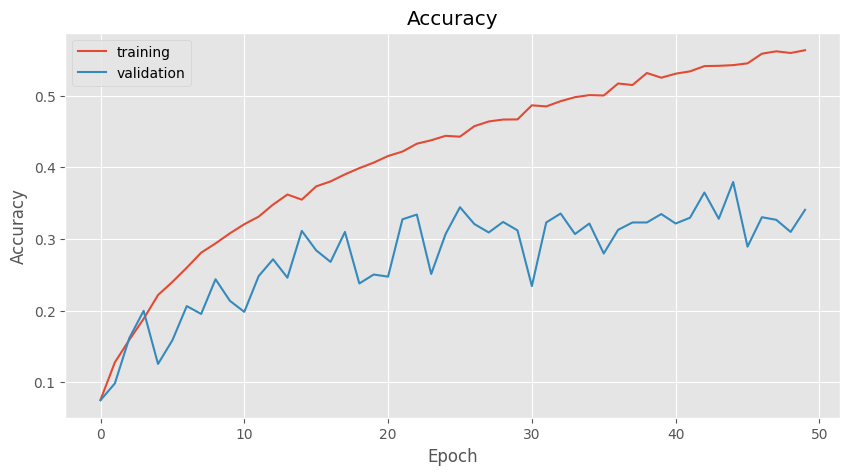

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(0, num_epochs), H.history["accuracy"], label="training")
plt.plot(np.arange(0, num_epochs), H.history["val_accuracy"], label="validation")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

In [ ]:
model.save_weights('weights/weights_InceptionV3-000/weights')

In [ ]:
import os
model.save(os.path.join('models/h5', 'explorentt_mobilenet.h5'))

In [ ]:
!tensorflowjs_converter --input_format=keras models/h5/explorentt_mobilenet.h5 models/h5-tfjs